In [1]:
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)



In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np
from sklearn.model_selection import KFold
from scipy.optimize import minimize
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




In [4]:
# @title Make a plot of which brain areas are present in each dataset
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]


In [5]:
brain_groups_vec=[]
for i in brain_groups:
    brain_groups_vec+=i

### Poisson GLM Function

In [6]:
def make_design_matrix(stim, d=25):
  """Create time-lag design matrix from stimulus intensity vector.

  Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.

  Returns
    X (2D array): GLM design matrix with shape T, d

  """

  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus proceeding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] =padded_stim[t:t + d]

  return X


In [7]:
def get_valid_trials(dat):
    
    
    reaction_times=np.squeeze(dat['reaction_time'][:,0])  
    cue_time=np.squeeze(dat['gocue'][:])                                      
    ind=(reaction_times[:]-cue_time[:]>0)   # and reaction_times[:]!=np.inf)
                                            #print("Index shape0: ", ind.shape)
    #ind=(reaction_times[ind]<np.inf)       #not sure why this reduce the dimension by 1

    return ind

def get_valid_spks(dat):    
    #print(dat['spks'].shape)
    spks=dat['spks'][:, get_valid_trials(dat)]
    return spks


        


def get_wheel_speed(dat):
        wheel=dat['wheel']
        wheel= wheel.squeeze()
        return wheel


def get_stacked_output_vec(wheel):
        """
        wheel: is a 2d array with the rows corresponding to trials and columns correspong to the time bin

        returns: 1-d vector with all the output values and 1st wheel.shape[1] elements will store speeds in the time bins of 1st trial and from 2wheel.shape[1]-wheel.shape[1] will store the wheel speeds of 2nd trial and so on 
        """
        wheel_set_vec=np.array([])
        for i in range(wheel.shape[0]):
            wheel_set_vec=np.concatenate([wheel_set_vec,wheel[i]]) 

        return wheel_set_vec
        
def get_stacked_design(spks_mean_neurons, d=25):
    
        X_stacked=make_design_matrix(spks_mean_neurons[0], d=25)
        for i in range(1,spks_mean_neurons.shape[0]):
            X_stacked=np.vstack([X_stacked, make_design_matrix(spks_mean_neurons[0], d=25)] )

        return X_stacked

    

In [8]:
def neg_log_lik_lnp(theta, X, y):
      """Return -loglike for the Poisson GLM model.
      Args:
        theta (1D array): Parameter vector.
        X (2D array): Full design matrix.
        y (1D array): Data values.
      Returns:
        number: Negative log likelihood.
      """
      # Compute the Poisson log likeliood
      rate = np.exp(X @ theta)
      #print(rate)
      #print(y)  
      log_lik = y @ X @ theta - rate.sum()
      return -log_lik


def fit_lnp(stim, spikes, d=25):
      """Obtain MLE parameters for the Poisson GLM.
      Args:
        stim (1D array): Stimulus values at each timepoint
        spikes (1D array): Spike counts measured at each timepoint
        d (number): Number of time lags to use.
      Returns:
        1D array: MLE parameters
      """
      # Build the design matrix
      y = spikes
      constant = np.ones_like(y)
      X = np.column_stack([constant, make_design_matrix(stim)])
      # Use a random vector of weights to start (mean 0, sd .2)
      x0 = np.random.normal(0, .2, d + 1)
      # Find parameters that minmize the negative log likelihood function
      res = minimize(neg_log_lik_lnp, x0, args=(X, y))
      return res["x"]

### Plotting Functions

In [9]:
def plot_spik_speed(MFR,wheel_,pre_reg_speed):
    fig, (ah1, ah2) = plt.subplots(2,figsize=(15,7))
   
    ah1.plot(pre_reg_speed, color='limegreen',label="Predicted Wheel Speed")
    ah1.plot(wheel_,label="Actual Wheel Speed")
    ah2.plot(MFR, color='limegreen',label="Predicted Wheel Speed")
    ah1.set(ylabel="Wheel-Speed(Ticks/10ms)")
    ah1.legend()
    ah2.set(xlabel="Time Step")
    ah2.set(ylabel='Mean firing/10ms')
    ah1.set(title="The Prediction of wheel speed mean spiking of ACA neurons")
    
    plt.show()

    



In [129]:
def plot_cross_validate_MSE(mse_all, labels, n_splits):
  """ Plot the MSE values for the K_fold cross validation

  Args:
    mse_all (ndarray): an array of size (number of splits, max_order + 1)
  """
  plt.figure()
  plt.boxplot(mse_all, labels=labels)

  plt.xlabel('Neuron Type')
  plt.ylabel('Validation MSE')
  plt.title(f'Validation MSE over {n_splits} splits of the data')


### Stacking Functions

In [107]:
def get_wheel_speed(dat):
        wheel=dat['wheel']
        wheel= wheel.squeeze()
        return wheel

def get_stacked_output_vec(wheel):
        """
        wheel: is a 2d array with the rows corresponding to trials and columns correspong to the time bin

        returns: 1-d vector with all the output values and 1st wheel.shape[1] elements will store speeds in the time bins of 1st trial and from 2wheel.shape[1]-wheel.shape[1] will store the wheel speeds of 2nd trial and so on 
        """
        wheel_set_vec=np.array([])
        for i in range(wheel.shape[0]):
            wheel_set_vec=np.concatenate([wheel_set_vec,wheel[i]]) 

        return wheel_set_vec
        


In [108]:
def get_stacked_design(spks_mean_neurons, d=25):
    
        X_stacked=make_design_matrix(spks_mean_neurons[0], d=25)
        for i in range(1,spks_mean_neurons.shape[0]):
            X_stacked=np.vstack([X_stacked, make_design_matrix(spks_mean_neurons[0], d=25)] )

        return X_stacked


### Segregation Functions


In [109]:
def get_brain_grp(dat, brain_group):
    
        
        dat_weaved=dict()
        grp_indices=(dat['brain_area'][:]==brain_group)## Take the indices where the data from neurons of the desired group is
        valid_trial_indices=get_valid_trials(dat)       ## take the valid trials
        spikes=get_valid_spks(dat)[grp_indices]         
        
        dat_weaved['spks']=spikes
        dat_weaved['wheel']=np.squeeze(dat['wheel'])[valid_trial_indices]
        dat_weaved['reaction_time']=dat['reaction_time'][valid_trial_indices]
        dat_weaved['contrast_right']=dat['contrast_right']
        dat_weaved['contrast_left']  =dat['contrast_left']
        dat_weaved['gocue'] =dat['gocue'] 
        dat_weaved['response_time']=dat['response_time']  
        dat_weaved['response'] =dat['response']
        dat_weaved['feedback_time']= dat['feedback_time']
        dat_weaved['feedback_type']= dat['feedback_type']   
        dat_weaved['count']=spikes.shape[0]
        dat_weaved['dt']=dat['bin_size']
        
        return dat_weaved

In [110]:
def get_areas(dat, brain_groups_vec):
        """
        gets a data dictionary from the session and returns the dictioary of the data keyed by the brain area
        
        """
        area=dict()
        
        for brain_area in brain_groups_vec:
            area_data=dict()
            area_data=get_brain_grp(dat, brain_area)   
            
            if area_data['count']!=0:
                area_data['spks_mean']=area_data['spks'].mean(axis=0)*area_data['dt']
                area_data['Stacked_Spiking']=get_stacked_output_vec(area_data['spks_mean'])
                area[brain_area]=area_data
                
        return area
        

### Model Evaluation

In [111]:
def evaluate_mse(x, y, theta_hats,d=25):
    """ Evaluates MSE of polynomial regression models on data

    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      theta_hat (dict):  fitted weights for each polynomial model (dict key is order)
      max_order (scalar): max order of polynomial fit

    Returns
      (ndarray): mean squared error for each order, shape (max_order)
    """


    X_design = make_design_matrix(x, d)
    
    constant = np.ones_like(range(X_design.shape[0]))
    X_design = np.column_stack([constant,X_design])
    
    y_hat = np.exp( X_design @theta_hats)
    residuals = y - y_hat
    mse = np.mean(residuals ** 2)

    return mse

In [112]:
def cross_validate(x_train, y_train, n_splits,d=25):
  """ Compute MSE for k-fold validation for each order polynomial

  Args:
    x_train (ndarray): training data input vector of shape (n_samples)
    y_train (ndarray): training vector of measurements of shape (n_samples)
    max_order (scalar): max order of polynomial fit
    n_split (scalar): number of folds for k-fold validation

  Return:
    ndarray: MSE over splits for each model order, shape (n_splits, max_order + 1)

  """

  # Initialize the split method
  kfold_iterator = KFold(n_splits)


  mse_all = []
  theta_all=[]  
  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(x_train)):

      # Split up the overall training data into cross-validation training and validation sets
      x_cv_train = x_train[train_indices]
      y_cv_train = y_train[train_indices]
      x_cv_val = x_train[val_indices]
      y_cv_val = y_train[val_indices]
    
    
      # Fit models
      theta_hats = fit_lnp(x_cv_train, y_cv_train,d)

      mse_all.append(evaluate_mse(x_cv_val,y_cv_val,theta_hats,d))
      theta_all.append(theta_hats)
        
  return (mse_all,theta_all)

In [113]:
def cross_validate_neuron_grp(areas, y_train,n_splits,d=25):
        
        MSE_vec=dict()
        theta=dict()
        for key in areas:
                MSE_v=cross_validate(areas[key]['Stacked_Spiking'], y_train, n_splits, d)
                MSE_vec[key]=MSE_v[0]
                theta[key]=MSE_v[1]

        return (MSE_vec, theta)
                

### Testing space

In [114]:
dat=alldat[0]
wheel=dat['wheel']
wheel= wheel.squeeze()
dt=dat['bin_size']
t_vec=dt*np.arange(wheel.shape[-1])


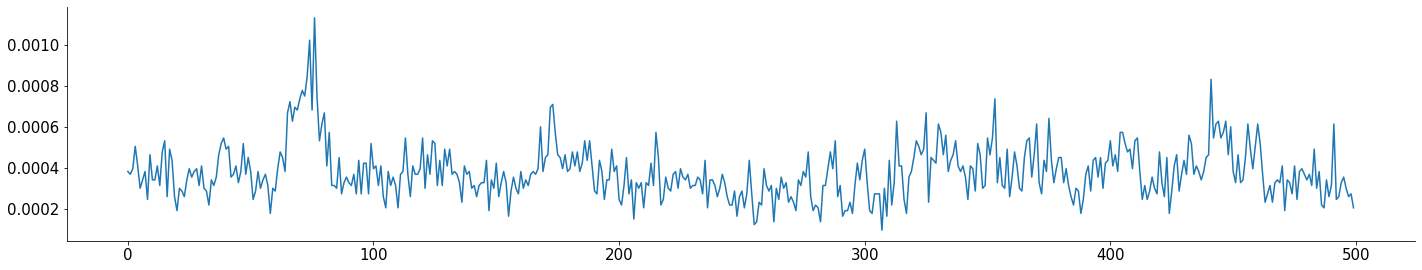

In [115]:
spk_mean=np.mean(dat['spks'],axis=0)
wheel=get_wheel_speed(dat)
dt = dat['bin_size']
wheel_stacked=get_stacked_output_vec(wheel)
compensation=-min(wheel_stacked)

wheel_stacked=get_stacked_output_vec(wheel)-min(wheel_stacked)
inp_neural_resp=dt*np.reshape(spk_mean, spk_mean.shape[0]*spk_mean.shape[1])
wheel_valid=wheel[get_valid_trials(dat)]
plt.plot(inp_neural_resp[0:500])


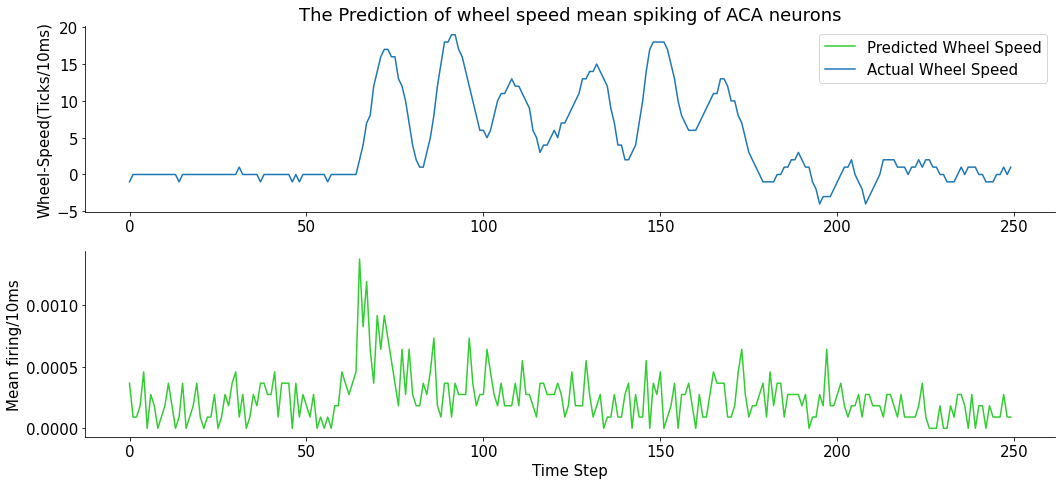

In [116]:
areas=get_areas(dat,brain_groups_vec)


plot_spik_speed(areas['ACA']['spks_mean'][0],wheel_valid[0],np.ones_like(len(wheel_valid)) )

In [117]:
labels=[key for key in areas]

In [118]:

wheel_valid=get_stacked_output_vec(wheel_valid)
n_split=3


In [119]:

validators=cross_validate_neuron_grp(areas,wheel_valid,3)

KeyboardInterrupt: 

In [148]:
def write_on_file(validators,session_num, n_splits,d=25):
    """
    validators: tuple of dictionaries returned by the function
    i: session number of the dataset
    
    """
    for keys in validators[1]:
        fname="{0}_session_{1}_d_{2}.txt".format(keys,session_num,d)
        try:    
            fhand=open(fname,"w")
        except:
            print("{0} couldn't be opened/accessed".format(fname))
        
        arr=[]
        [arr.append( np.array(validators[i][keys]) ) for i in range(len(validators))]
        
        for ar in arr:
            np.savetxt(fhand, ar)
        
        fhand.close()
            
    
                    
                
                
        

In [149]:
write_on_file(validators, 0, n_split)

In [ ]:
def stack_label_err(labels, validators):
    
    stacked_= np.array(validators[0][labels[0]]).T
    for label_ in range(1,len(labels)):
        
        stacked_=np.column_stack([stacked_,np.array(validators[0][labels[label_]]).T])
    
    return stacked_

In [92]:
bplt_dat=stack_label_err(labels, validators)
print(bplt_dat.shape,len (labels))

(3, 7) 7


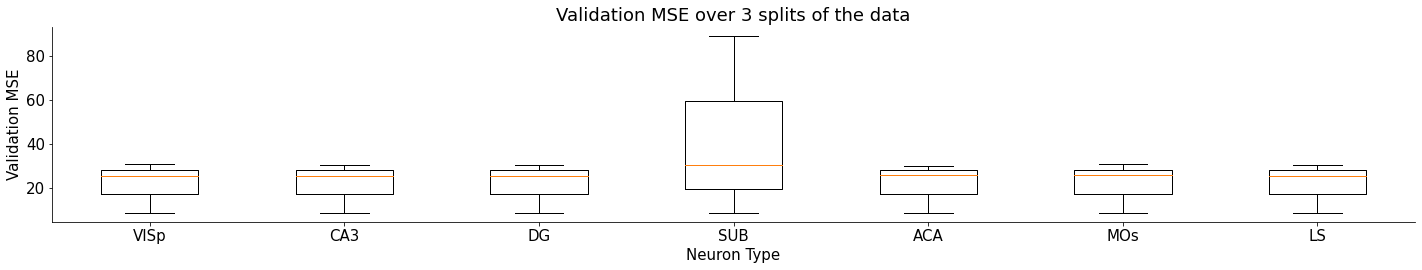

In [130]:
plot_cross_validate_MSE(bplt_dat, labels, n_split)

<function matplotlib.pyplot.show(close=None, block=None)>

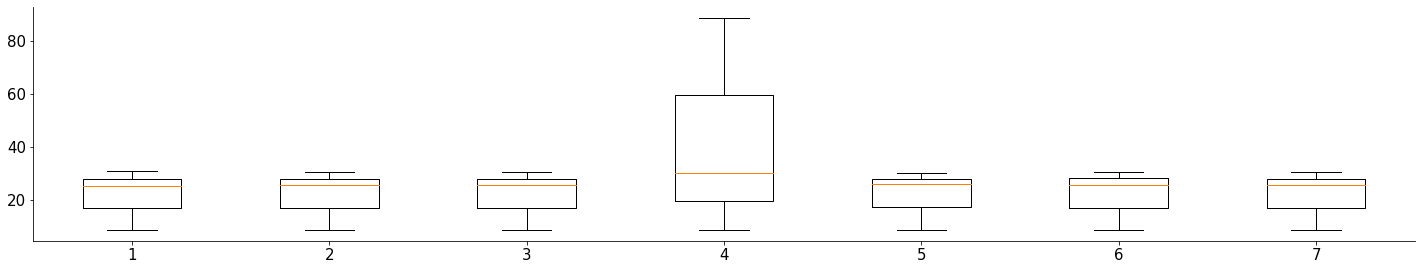

In [104]:
plt.boxplot(bplt_dat)
plt.show

In [133]:

a_file = open("test.txt", "w")
np.savetxt(a_file, ar)
np.savetxt(a_file, arr)
a_file.close()